In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

# **Data Preperation**

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = [] #For Images
y_train = [] #For storing labels
image_size = 150
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 82.06it/s]


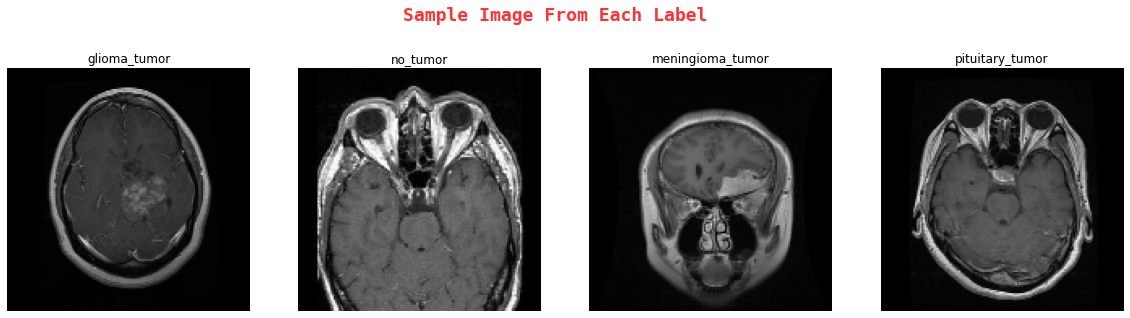

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color='red',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(3264, 150, 150, 3)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [9]:
print("Lenght of test dataset is:",len(X_test) )
print("Lenght of test dataset is:",len(X_train) )
total=len(X_test)+len(X_train)
print("Total images are",total)
ratio=len(X_train)/total
train_ratio=ratio*100
test_ratio=(len(X_test)/total)*100
print("the ratio of test train split is",round(train_ratio),":",round(test_ratio))


Lenght of test dataset is: 653
Lenght of test dataset is: 2611
Total images are 3264
the ratio of test train split is 80 : 20


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\sipsm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

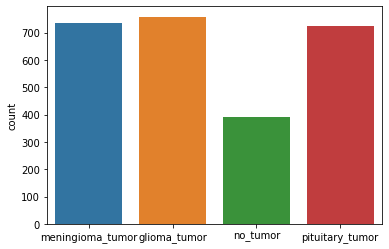

In [11]:
sns.countplot(y_train)

C:\Users\sipsm\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

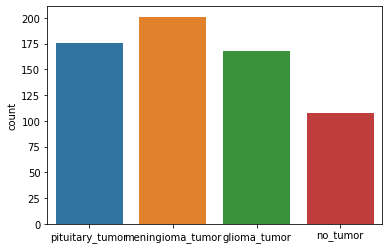

In [12]:
sns.countplot(y_test)

In [13]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [14]:
from glob import glob 
folders = glob('Training/*')

# **Transfer Learning**

In [15]:
effnet = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [16]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
x = Flatten()(effnet.output)

In [17]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [18]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [19]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [20]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

# **Training The Model**

In [21]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/10
 1/74 [..............................] - ETA: 0s - loss: 1.3909 - accuracy: 0.3750WARNING:tensorflow:From C:\Users\sipsm\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
74/74 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.7944
Epoch 00001: val_accuracy improved from -inf to 0.86260, saving model to effnet.h5
74/74 [==============================] - 439s 6s/step - loss: 0.5478 - accuracy: 0.7944 - val_loss: 0.4613 - val_accuracy: 0.8626
Epoch 2/10
74/74 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9238
Epoch 00002: val_accuracy improved from 0.86260 to 0.90840, saving model to effnet.h5
74/74 [==============================] - 522s 7s/step - loss: 0.2202 - accuracy: 0.9238 - val_loss: 0.2987 - val_accuracy: 0.9084
Epoch 3/10
74/74 [=

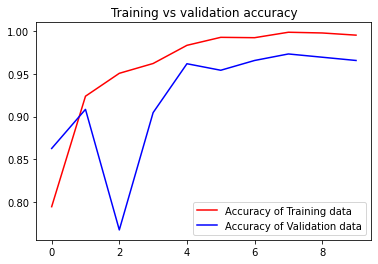

<Figure size 432x288 with 0 Axes>

In [22]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

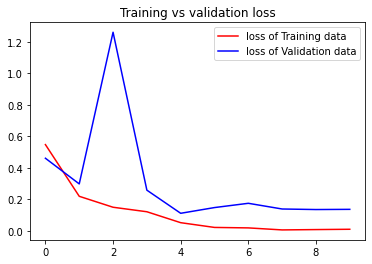

<Figure size 432x288 with 0 Axes>

In [23]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# **Prediction**

In [24]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

# **Evaluation**

In [25]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       168
           1       0.94      0.98      0.96       108
           2       0.94      0.94      0.94       201
           3       0.98      0.97      0.97       176

    accuracy                           0.95       653
   macro avg       0.95      0.96      0.95       653
weighted avg       0.95      0.95      0.95       653



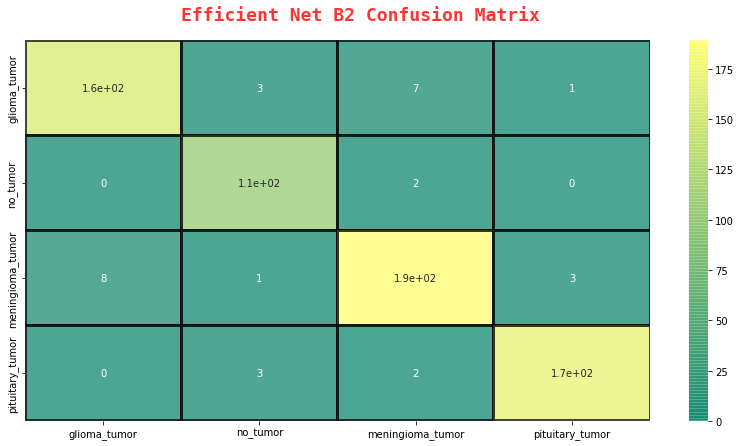

In [26]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap='summer',alpha=0.7,linewidths=2,linecolor='black')
fig.text(s='Efficient Net B2 Confusion Matrix ',size=18,fontweight='bold',
             fontname='monospace',color='red',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [27]:
from tensorflow.keras.models import load_model

model.save('efficient_b2.h5')

In [28]:
pred

array([3, 2, 0, 1, 3, 2, 2, 3, 2, 2, 2, 0, 0, 1, 2, 3, 3, 2, 3, 2, 3, 0,
       1, 1, 1, 3, 1, 3, 3, 3, 2, 3, 0, 2, 3, 2, 3, 2, 0, 2, 2, 2, 3, 2,
       2, 3, 0, 2, 3, 0, 2, 0, 3, 3, 2, 3, 0, 3, 1, 0, 2, 2, 1, 0, 3, 3,
       3, 0, 2, 0, 0, 0, 3, 1, 0, 2, 0, 0, 2, 1, 2, 2, 3, 3, 0, 0, 2, 2,
       2, 1, 1, 3, 2, 2, 0, 2, 0, 2, 3, 2, 2, 0, 0, 2, 1, 3, 3, 0, 0, 2,
       1, 0, 3, 0, 3, 0, 1, 3, 2, 1, 0, 1, 3, 0, 3, 3, 1, 3, 3, 0, 1, 0,
       1, 3, 2, 2, 2, 3, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 2, 2, 3, 1, 2, 3,
       2, 3, 1, 1, 2, 0, 3, 2, 1, 2, 0, 0, 0, 1, 0, 2, 2, 3, 3, 1, 2, 1,
       0, 0, 3, 0, 3, 0, 1, 0, 3, 2, 2, 1, 2, 1, 2, 1, 0, 2, 2, 2, 1, 1,
       2, 2, 3, 0, 3, 2, 2, 3, 2, 1, 1, 0, 2, 2, 2, 0, 0, 3, 0, 0, 3, 0,
       2, 1, 3, 1, 3, 0, 1, 1, 3, 2, 0, 0, 3, 0, 0, 2, 3, 3, 0, 0, 1, 0,
       2, 2, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 3, 1, 3, 3, 0, 3, 3, 1,
       0, 0, 0, 1, 2, 0, 0, 3, 3, 3, 0, 3, 2, 1, 0, 1, 2, 1, 3, 3, 1, 2,
       0, 1, 1, 0, 2, 2, 2, 3, 3, 2, 3, 0, 0, 3, 2,

In [29]:
pred=pred.flatten().astype(int)

In [30]:
y_test_new=y_test_new.flatten().astype(int)

In [31]:
df = pd.DataFrame({'Actual': y_test_new, 'Predicted': pred})

In [32]:
df.head(10)

,Actual,Predicted
0,3,3
1,2,2
2,0,0
3,1,1
4,3,3
5,2,2
6,2,2
7,3,3
8,2,2
9,2,2
